In [1]:
#General Imports
import pandas as pd
import seaborn as sns
from math import ceil
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random as rnd
from time import perf_counter as time
import numpy as np
from sklearn.impute import SimpleImputer
from preprocessing_utils import drop_features_, fill_nan_values

In [2]:
dataset_fpath = '../data/BTS1_BTS2_fields_preserved.zip'
nidd_dataset = pd.read_csv(dataset_fpath, compression = 'zip', low_memory=False)

#Attack Type for Multi-Class Classification or Label for Binary Classification
TARGET = 'Label'
DROPPED_TARGET = "Label" if TARGET == "Attack Type" else "Attack Type"

useless_features = ['Attack Tool', DROPPED_TARGET, 'Dport', 'Sport', 'SrcAddr', 'DstAddr',"Unnamed: 0"]
nidd_dataset = nidd_dataset.drop(useless_features, axis=1)
print(f"Original shape of data: {nidd_dataset.shape}")

Original shape of data: (1215890, 106)


In [3]:
features_dropped = {"Nan columns": [], "Zero columns": [], "Constant columns": [], "General columns": useless_features}
preprocessing_d = {"Time <Dropping features based on a threshold `bad` values>": 0.,
                   "Filling NaNs": 0.,
                   "Time <Encoding categorical features>": 0.,
                   "Time <Feature selection>": 0.}



nidd_dataset_cleaned, drop_time = drop_features_(nidd_dataset,[0.95, 0.95], features_dropped)
preprocessing_d["Time <Dropping features based on a threshold `bad` values>"] = drop_time

nidd_dataset_cleaned, fill_time = fill_nan_values(nidd_dataset_cleaned, method = "mean")
preprocessing_d["Filling NaNs"] = fill_time

numeric_cols = nidd_dataset_cleaned.select_dtypes(include='number').columns
categorical_cols = nidd_dataset_cleaned.select_dtypes(include='object').columns

t0 = time()
# Encoding categorical columns
label_encoder = LabelEncoder()
for column in categorical_cols:
    nidd_dataset_cleaned[column] = label_encoder.fit_transform(nidd_dataset_cleaned[column])

t1 = time()
preprocessing_d["Time <Encoding categorical features>"] = t1 - t0

After dropping NaN columns: (1215890, 70)
After dropping NaN & Zero columns: (1215890, 55)
After dropping NaN & Zero & Constant columns: (1215890, 51)


In [4]:

feature_extraction_model = RandomForestClassifier(random_state= rnd.seed(42))
feature_extraction_model.fit(nidd_dataset_cleaned.iloc[:,:-1], nidd_dataset_cleaned[TARGET])

print(f"Feature importance: {feature_extraction_model.feature_importances_}")


Feature importance: [9.23681230e-02 3.16078956e-02 2.84415061e-02 4.89201700e-02
 2.14907420e-01 1.66798899e-03 3.11696938e-03 7.81623433e-02
 5.82938229e-03 2.28493394e-03 3.05782419e-03 2.32926585e-03
 1.24050705e-02 1.18567657e-03 2.02874892e-04 2.32035965e-06
 9.21838110e-02 8.96181530e-03 5.43085846e-02 1.00206389e-02
 1.15316360e-03 2.64310113e-04 3.08100713e-03 1.53525198e-03
 1.30112906e-04 3.78130255e-04 1.23866867e-02 1.62788573e-02
 3.20680300e-03 1.01486448e-01 4.96183223e-02 1.96254595e-03
 3.44077344e-03 3.06318118e-03 8.06999538e-05 1.10749859e-02
 1.80939525e-02 5.51882901e-03 4.05082790e-03 3.53444765e-04
 6.71328413e-03 1.53464728e-02 1.87846202e-02 3.21121221e-03
 2.05389961e-03 6.22521874e-06 6.35541755e-03 1.37711841e-02
 3.52591809e-03 1.10881803e-03]


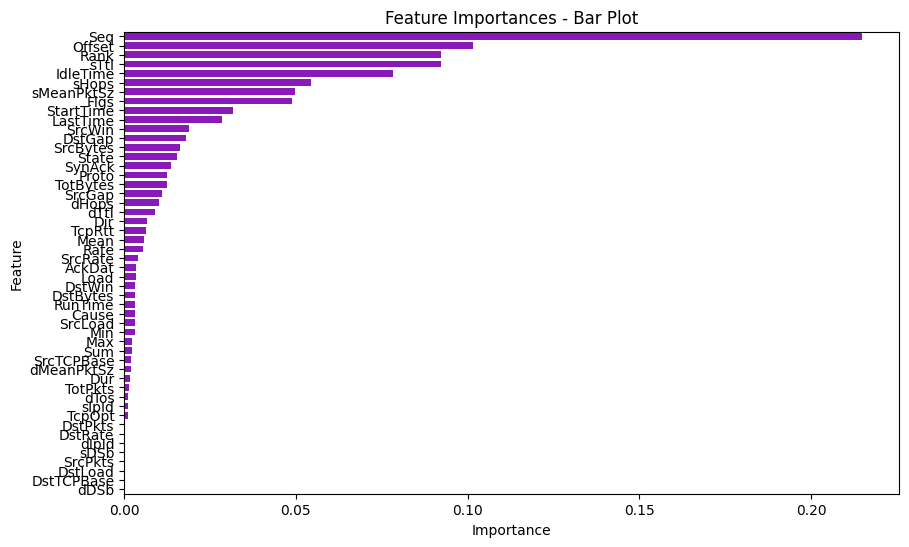

In [5]:
feature_importances_ = pd.DataFrame({'Feature': nidd_dataset_cleaned.iloc[:,:-1].columns, 
                                    'Importance': feature_extraction_model.feature_importances_})

# print(f"Feature importance: {feature_importances_}")
# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', 
            data=feature_importances_.sort_values(by='Importance', ascending=False),
            width = 1.2, gap = 0.4,
            color = "darkviolet")
plt.title('Feature Importances - Bar Plot')
plt.show()




In [6]:

top_10_features_cols = feature_importances_.sort_values(by='Importance', ascending=False).head(10)['Feature'].values
print(top_10_features_cols)
target = nidd_dataset_cleaned[TARGET]
features = nidd_dataset[top_10_features_cols]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=rnd.seed(42)) 

numeric_features = list(set(numeric_cols) & set(top_10_features_cols))
categorical_features = list(set(categorical_cols) & set(top_10_features_cols))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)



['Seq' 'Offset' 'Rank' 'sTtl' 'IdleTime' 'sHops' 'sMeanPktSz' 'Flgs'
 'StartTime' 'LastTime']


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sMeanPktSz', 'Seq', 'sTtl',
                                                   'sHops', 'IdleTime', 'Rank',
                                                   'Offset']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['StartTime', 'Flgs',
                                                   'LastTime'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [7]:
# print(X_train.columns)
# print(X_test.columns)
for column in categorical_features:
    X_test[column] = label_encoder.fit_transform(X_test[column])
    
predictions = pipeline["classifier"].predict(X_test)

/home/dimet/Documents/Dimitris/ceid/5G_Intrusion_detection/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 10 features, but DecisionTreeClassifier is expecting 61966 features as input.

In [ ]:
conf_matrix = confusion_matrix(y_test, predictions)

target_categories = set(nidd_dataset[TARGET])

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(target_categories)), labels=target_categories, rotation=45)
plt.yticks(ticks=np.arange(len(target_categories)), labels=target_categories)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

class_report = classification_report(y_test, predictions, target_names=target_categories , digits=6)
print("Classification Report:\n", class_report)
for key, time in preprocessing_d.items():
    print(f"{key}: {time:.4f} seconds")


In [ ]:

test_con = pd.concat([X_test, y_test], axis=1)
sample = test_con.sample(frac= 0.6)
# print(sample.isna().sum())
sample.replace(to_replace= np.nan, value = "NaN", inplace=True)
# print(sample.isna().sum())

print(sample.dtypes)
print(sample["LastTime"].head(4))
# with open("../data/test_sample.csv", "w") as f:
#     sample.to_csv(f, index=False)
